# Brain Tumor MRI Data Exploration and Preprocessing

We explore and preprocess a brain tumor MRI dataset from Kaggle by visualizing raw images and then applying appropriate image transformations to prepare the data for downstream tasks such as applying our deep learning architectures for tumour classification.

In [8]:
# Import libraries
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Set seed for reproducibility
random.seed(42)


In [ ]:
# import our own modules
import sys
sys.path.append('../src')  # Add the src directory to the Python path
from config.data import data_setup, data_loader, display_sample
from utils.visualization import plot_pixel_distribution, plot_class_distribution, plot_original_vs_transformed

In [ ]:
# Load data and data_loaders
train_set, test_set, label_conversion_dict = data_setup()
train_loader, test_loader = data_loader(train_set, test_set)

# Extract class labels
class_labels = list(label_conversion_dict.keys())[:4]

../src/config/data.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique['label'] = df_unique['filepath'].apply(lambda x: x.split('/')[-2])
../src/config/data.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique['class'] = df_unique['filename'].apply(lambda x: 'train' if x[:2] == 'Tr' else 'test')
100%|██████████| 6726/6726 [00:02<00:00, 2301.08it/s]


Initial number of samples in train set: 5521
Initial number of samples in test set: 1205
Total samples in train set after overriding labels: 5521
Total samples in test set after overriding labels: 1205
Total files in train set: 5521, with target values: [0, 1, 2, 3]
Total files in test set: 1205, with target values: [0, 1, 2, 3]


Let's display a random sample of images

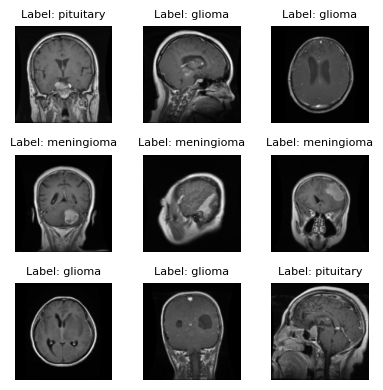

In [ ]:
# Display sample of images
display_sample(train_set)

In [35]:
# This is the transformation we have applied
print(train_set.transform)

Compose(
    Grayscale(num_output_channels=1)
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.5], std=[0.5])
)


**Transformation Pipeline Explanation**

- **Grayscale:**  
  The images initially have 3 channels (RGB), but since the channels are just copies of each other, we convert them to grayscale without losing any significant information. This reduces the image to a single channel.

- **Resize:**  
  Many of the images are different sizes (e.g., 168x300x3 vs. 198x150x3) so let's standardize all images to 128x128 pixels for a consistent input size.

- **ToTensor:**  
  Convert the image into a PyTorch tensor and scale pixel values between 0 and 1 (which are originally between 0 and 255, as is common with images).

- **Normalize:**  
  The pixel values are then normalized by subtracting 0.5 and dividing by 0.5. This transforms the pixel values from the [0.0, 1.0] range to the range [-1.0, 1.0], which is commonly expected by neural network


In [12]:
# Compute class counts for train/test
train_class_counts = [sum(1 for _, label in train_set if label == i) for i in range(len(class_labels))]
test_class_counts = [sum(1 for _, label in test_set if label == i) for i in range(len(class_labels))]

### Let's examine the distribution of classes for the training and testing set, and then look at the pixel intensities of a sample image to help us understand what's going on

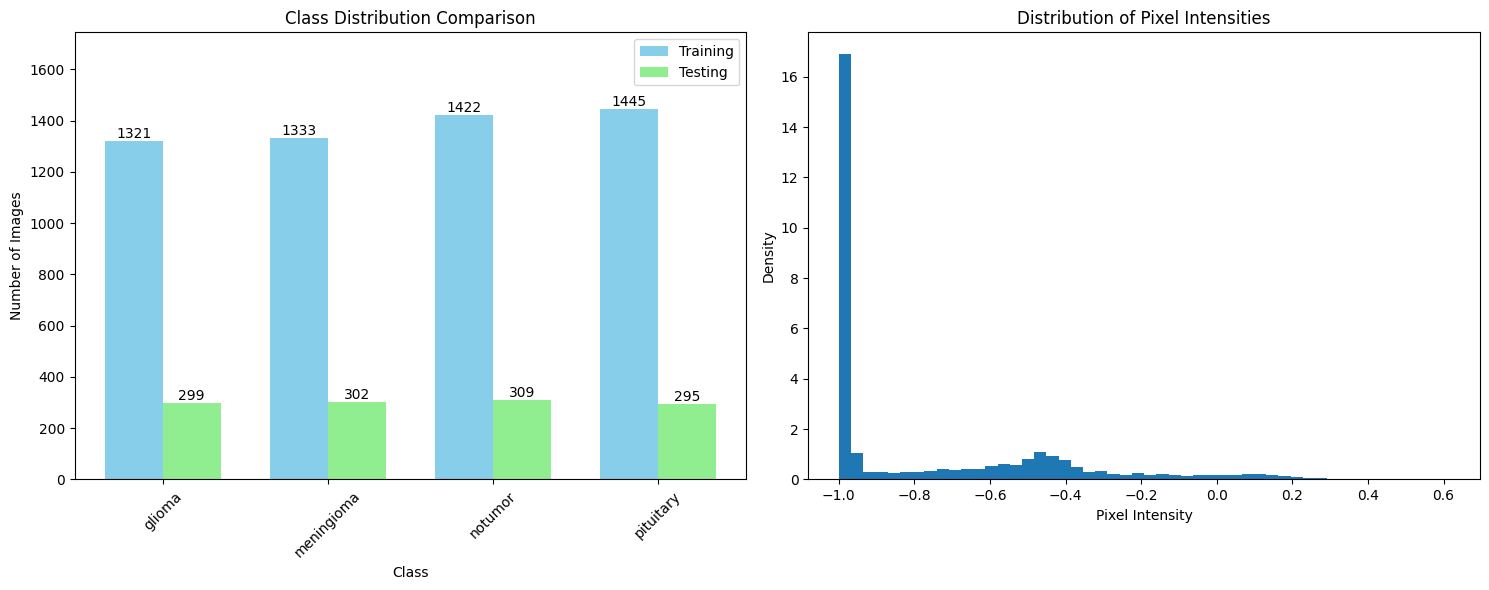

In [ ]:
img_trans_example, _ = train_set[0]

# Create figure for out plots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))  # 1 row, 2 columns

# Plot the distribution of each class for training and testing sets
plot_class_distribution(train_class_counts, test_class_counts, class_labels, axs[0])

# Show pixel intensities for the first image from train_set
plot_pixel_distribution(img_trans_example, axs[1])

# Show the figure
plt.tight_layout()
plt.show()

The bar charts on the left show a relatively even distribution across the three classes and healthy patients (i.e., 'notumor')

This histogram on the right shows the distribution of pixel intensities after applying our transformation pipeline. Most pixel values are ~ -1.0 since our normalization subtracts 0.5 and divides by 0.5, i.e., they are around 0 in the original image, as we would expect for a lot of the outer pixels (i.e., outside the brain where the image is black).

Next let's compare some of the original images to their transformed versions to check the transformed versions are consistent.

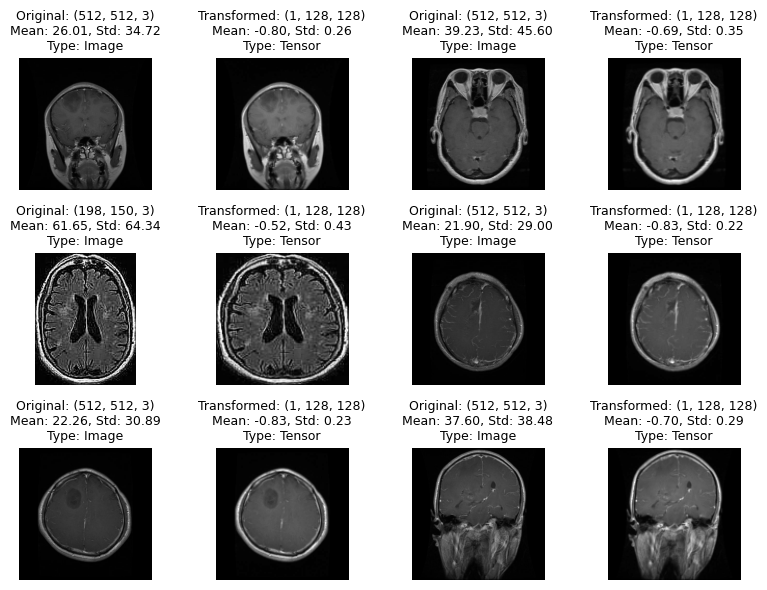

In [ ]:
plot_original_vs_transformed(train_set, train_set.transform)

We can see that we've transformed images of different sizes to a consistent size which will be accepted by the CNNs we will use subsequently, and the images have been transformed to tensors, which is a requirement for PyTorch which we will be using. Also, the mean and standard deviations go from values we would expect given pixel intensities between 0 and 255 to values that we would expect given the transformed intensities between [-1, 1], suggested our transformations are working correctly.

## Summary
The dataset consists of 5,521 training samples and 1,205 testing samples, covering brain tumor types such as glioma, meningioma, notumor, and pituitary. Preprocessing steps were applied to standardize and prepare the images for deep learning models. These included converting images to grayscale to reduce redundancy, resizing them to 128x128 pixels for consistency, converting to PyTorch tensors, and normalizing pixel values to stabilize training.

These preprocessing techniques ensure that the model receives consistent input, helping to improve training stability and generalization. Given the size of the dataset, future work may involve data augmentation to further enhance model performance.

This preprocessing pipeline provides a solid foundation for training and optimizing deep learning models for brain tumor classification tasks.